In [1]:



import numpy
import torch
from rasterio.features import rasterize
from shapely.affinity import translate
from shapely.geometry import Point
from torch.utils.data import Dataset


In [2]:
import random
import numpy as np
from shapely.affinity import rotate, scale
from shapely.geometry import shape, LineString, Polygon

class RandomTransform(torch.nn.Module):

  def __init__(self, scale_range=(0.5, 1.5), rotation_range=(-45, 45), noise_level=0.1, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.scale_range = scale_range
    self.rotation_range = rotation_range
    self.noise_level = noise_level

  def __call__(self, feature):
    # Random scale
    scale_factor = random.uniform(*self.scale_range)
    feature = scale(feature, xfact=scale_factor, yfact=scale_factor, origin='center')

    # Random rotation
    angle = random.uniform(*self.rotation_range)
    feature = rotate(feature, angle, origin='center')

    # Add noise
    if isinstance(feature, Polygon):
      coords = np.array(feature.exterior.coords)
      noise = np.random.normal(0, self.noise_level, coords.shape)
      noisy_coords = coords + noise
      feature = shape({'type': 'Polygon', 'coordinates': [noisy_coords]})
    elif isinstance(feature, LineString):
      coords = np.array(feature.coords)
      noise = np.random.normal(0, self.noise_level, coords.shape)
      noisy_coords = coords + noise
      feature = LineString(noisy_coords)

    return feature

In [3]:


class Noiser(torch.nn.Module):

  def __init__(
      self,
      noise_categories,
      noise_min=5,
      noise_max=10,
      raster_size_xy=(1024, 1024),
      scale_range=(0.5, 1.5),
      rotation_range=(-45, 45), *args, **kwargs
      ):
    super().__init__(*args, **kwargs)
    self.noise_categories = noise_categories
    self.noise_min = noise_min
    self.noise_max = noise_max
    self.raster_size_xy = raster_size_xy
    self.scale_range = scale_range
    self.rotation_range = rotation_range

  def __call__(self, raster):
    noise_features = self.sample_noise_features()
    noise_raster = self.features_to_raster(noise_features)
    return numpy.maximum(raster, noise_raster)

  def sample_noise_features(self):
    noise_features = []

    for category, features in self.noise_categories.items():
      noise_features.extend(
          random.sample(features, min(random.randint(self.noise_min, self.noise_max), len(features)))
          )

    return noise_features

  def features_to_raster(self, features):
    shapes = [(self.random_transform(feature), 1) for feature in features]
    noise_raster = rasterize(
        shapes, out_shape=self.raster_size_xy, fill=0, default_value=255, dtype=numpy.uint8
        )
    return noise_raster

  def random_transform(self, feature):
    # Random scale
    scale_factor = random.uniform(*self.scale_range)
    feature = scale(feature, xfact=scale_factor, yfact=scale_factor, origin='center')

    # Random rotation
    angle = random.uniform(*self.rotation_range)
    feature = rotate(feature, angle, origin='center')

    # Random translation
    minx, miny, maxx, maxy = feature.bounds
    width, height = maxx - minx, maxy - miny
    x_offset = random.randint(0, self.raster_size_xy[0] - int(width))
    y_offset = random.randint(0, self.raster_size_xy[1] - int(height))
    return translate(feature, xoff=x_offset - minx, yoff=y_offset - miny)

In [4]:
class ShapelyFeatureDataset(Dataset):

  def __init__(
      self,
      categories,
      coord_transform=None,
      noiser=None,
      subset_size=5,
      raster_size_xy: tuple[int, int] = (1024, 1024)
      ):
    self.categories = categories
    self.transform = coord_transform
    self.subset_size = subset_size
    self.raster_size_xy = raster_size_xy
    self.noiser = noiser

  def __len__(self):
    return sum(len(features) for features in self.categories.values())

  def __getitem__(self, idx):
    subset = self.sample_subset()
    rasters, masks = self.features_to_rasters(subset)
    return rasters, masks

  def sample_subset(self):
    subset = []

    for category, features in self.categories.items():
      subset.extend(random.sample(features, min(self.subset_size, len(features))))

    return subset

  def features_to_rasters(self, features):
    rasters = []
    masks = []
    placed_features = []
    for feature in features:
      if self.transform:
        feature = self.transform(feature)

      feature = self.ensure_no_overlap(feature, placed_features)
      raster, mask = self.feature_to_raster(feature)

      if self.noiser:
        raster = self.noiser(raster)

      rasters.append(raster)
      masks.append(mask)
      placed_features.append(feature)

    return rasters, masks

  def ensure_no_overlap(self, feature, placed_features):
    minx, miny, maxx, maxy = feature.bounds
    width, height = maxx - minx, maxy - miny
    while True:
      x_offset = random.randint(0, self.raster_size_xy[0] - int(width))
      y_offset = random.randint(0, self.raster_size_xy[1] - int(height))
      translated_feature = translate(feature, xoff=x_offset - minx, yoff=y_offset - miny)
      if not any(translated_feature.intersects(pf) for pf in placed_features):
        return translated_feature

  def feature_to_raster(self, feature):
    shapes = [(feature, 1)]
    raster = rasterize(shapes, out_shape=self.raster_size_xy, fill=0, default_value=255, dtype=numpy.uint8)
    mask = rasterize(shapes, out_shape=self.raster_size_xy, fill=0, default_value=1, dtype=numpy.uint8)

    return raster, mask

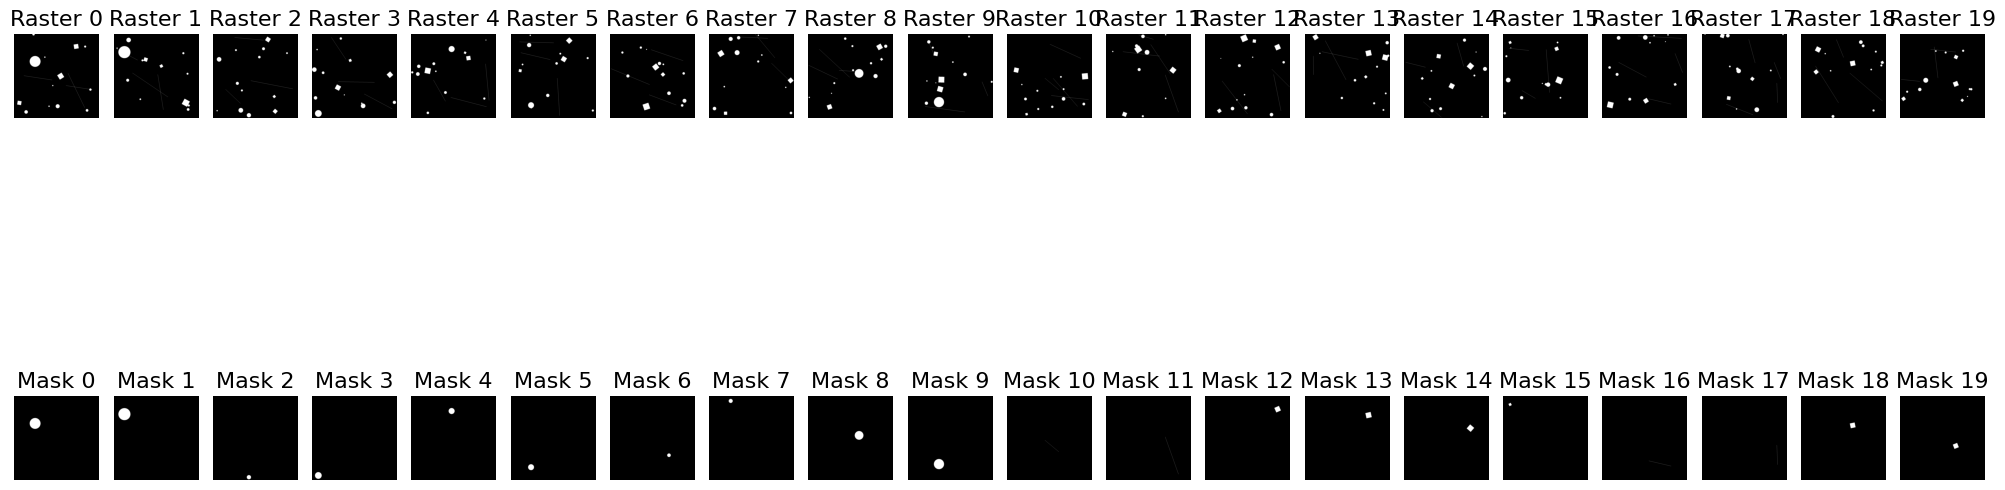

In [5]:


from matplotlib import pyplot

categories = {
    'chairs': [Point(128, 128).buffer(50) for _ in range(3)],
    'tables': [Point(64, 64).buffer(30) for _ in range(3)],
    'carpets': [Point(192, 192).buffer(40) for _ in range(3)],
    'plants': [Point(32, 32).buffer(20) for _ in range(3)],
    'walls': [Point(160, 160).buffer(60) for _ in range(3)],
    'roads': [LineString([(0, 0), (256, 256)]) for _ in range(3)],
    'buildings': [Polygon([(0, 0), (50, 0), (50, 50), (0, 50)]) for _ in range(3)],
    'parks': [Polygon([(100, 100), (150, 100), (150, 150), (100, 150)]) for _ in range(3)],
    'rivers': [LineString([(50, 50), (200, 200)]) for _ in range(3)],
    'lakes': [Polygon([(200, 200), (250, 200), (250, 250), (200, 250)]) for _ in range(3)]
    }
coords_random_transform = RandomTransform()

# Define noise categories including LineString
noise_categories = {
    'noise1': [Point(128, 128).buffer(10) for _ in range(3)],
    'noise2': [Point(64, 64).buffer(15) for _ in range(3)],
    'noise3': [Point(192, 192).buffer(20) for _ in range(3)],
    'lines': [LineString([(0, 0), (256, 256)]) for _ in range(3)],
    'polys': [Polygon([(200, 200), (250, 200), (250, 250), (200, 250)]) for _ in range(3)]
    }

# Create Noiser instance
noiser = Noiser(noise_categories)

dataset = ShapelyFeatureDataset(
    categories,
    #coord_transform=torch.nn.Sequential(coords_random_transform, noiser),
    coord_transform=coords_random_transform,
    noiser=noiser,
    subset_size=2
    )

# Get a sample
rasters, masks = dataset.__getitem__(0)

# Visualize the rasters
fig, axes = pyplot.subplots(2, len(rasters), figsize=(20, 10))  # Increase figure size
for i, (mask, raster) in enumerate(zip(masks, rasters)):
  axes[0, i].imshow(raster, cmap='gray')
  axes[0, i].set_title(f'Raster {i}', fontsize=16)  # Increase title font size
  axes[1, i].imshow(mask, cmap='gray')
  axes[1, i].set_title(f'Mask {i}', fontsize=16)  # Increase title font size
  axes[0, i].axis('off')
  axes[1, i].axis('off')

pyplot.tight_layout()  # Adjust layout to prevent overlap
pyplot.show()